# Importing Libraries

In [81]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from tensorflow.keras.utils import np_utils, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [82]:
# Paths for data.
Ravdess = "input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "input/cremad/AudioWAV/"
Tess = "input/toronto-emotional-speech-set-tess/"
Savee = "input/surrey-audiovisual-expressed-emotion-savee/ALL/"

##  <center> 1. Ravdess Dataframe <center>

In [83]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0    angry  input/ravdess-emotional-speech-audio/audio_spe...
1     fear  input/ravdess-emotional-speech-audio/audio_spe...
2     fear  input/ravdess-emotional-speech-audio/audio_spe...
3    angry  input/ravdess-emotional-speech-audio/audio_spe...
4  disgust  input/ravdess-emotional-speech-audio/audio_spe...

## <center>2. Crema DataFrame</center>

In [84]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                       Path
0    angry  input/cremad/AudioWAV/1022_ITS_ANG_XX.wav
1    angry  input/cremad/AudioWAV/1037_ITS_ANG_XX.wav
2  neutral  input/cremad/AudioWAV/1060_ITS_NEU_XX.wav
3  neutral  input/cremad/AudioWAV/1075_ITS_NEU_XX.wav
4  disgust  input/cremad/AudioWAV/1073_IOM_DIS_XX.wav

##  <center> 3. TESS dataset <center>

In [85]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    if not dir.startswith('.'):
        directories = os.listdir(Tess + dir)
        for file in directories:
            part = file.split('.')[0]
            part = part.split('_')[2]
            if part=='ps':
                file_emotion.append('surprise')
            else:
                file_emotion.append(part)
            file_path.append(Tess + dir + '/' + file)
            
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0  disgust  input/toronto-emotional-speech-set-tess/YAF_di...
1  disgust  input/toronto-emotional-speech-set-tess/YAF_di...
2  disgust  input/toronto-emotional-speech-set-tess/YAF_di...
3  disgust  input/toronto-emotional-speech-set-tess/YAF_di...
4  disgust  input/toronto-emotional-speech-set-tess/YAF_di...

##  <center> 4. CREMA-D dataset <center>
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [86]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    if not file.startswith('.'):
        file_path.append(Savee + file)
        part = file.split('_')[1]
        ele = part[:-6]
        if ele=='a':
            file_emotion.append('angry')
        elif ele=='d':
            file_emotion.append('disgust')
        elif ele=='f':
            file_emotion.append('fear')
        elif ele=='h':
            file_emotion.append('happy')
        elif ele=='n':
            file_emotion.append('neutral')
        elif ele=='sa':
            file_emotion.append('sad')
        else:
            file_emotion.append('surprise')
            
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0       sad  input/surrey-audiovisual-expressed-emotion-sav...
1       sad  input/surrey-audiovisual-expressed-emotion-sav...
2   neutral  input/surrey-audiovisual-expressed-emotion-sav...
3  surprise  input/surrey-audiovisual-expressed-emotion-sav...
4   neutral  input/surrey-audiovisual-expressed-emotion-sav...

In [87]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0    angry  input/ravdess-emotional-speech-audio/audio_spe...
1     fear  input/ravdess-emotional-speech-audio/audio_spe...
2     fear  input/ravdess-emotional-speech-audio/audio_spe...
3    angry  input/ravdess-emotional-speech-audio/audio_spe...
4  disgust  input/ravdess-emotional-speech-audio/audio_spe...

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

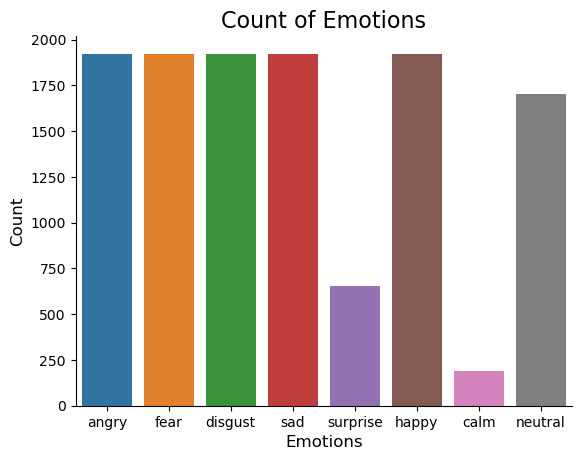

In [88]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [89]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

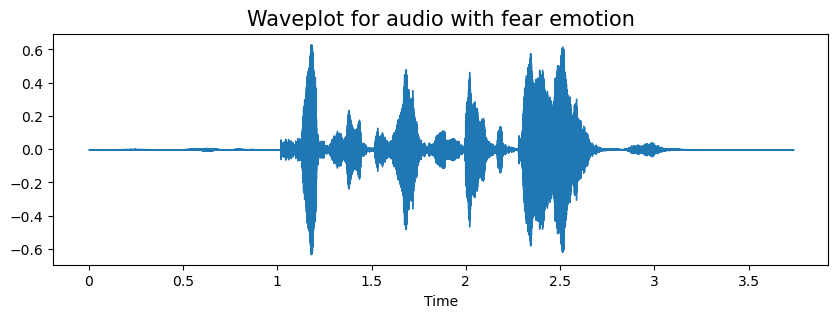

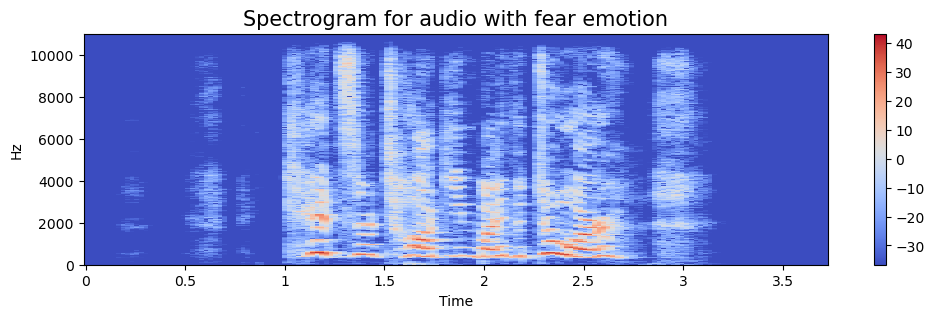

In [90]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

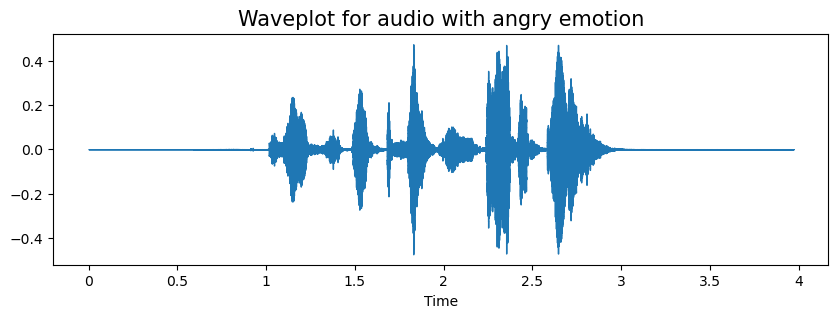

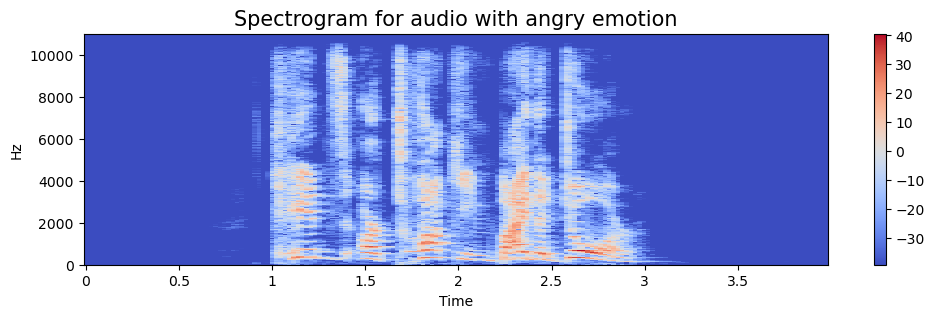

In [91]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

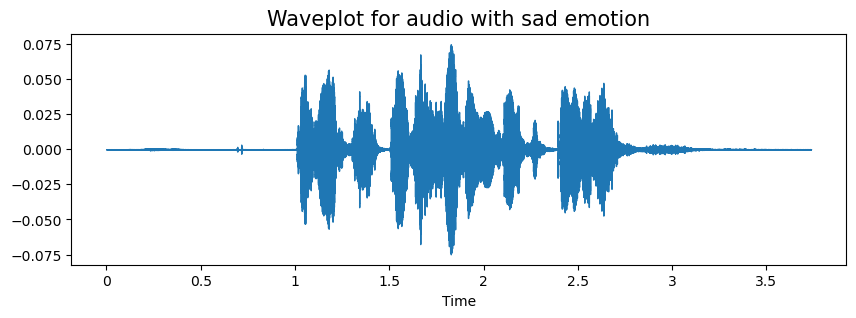

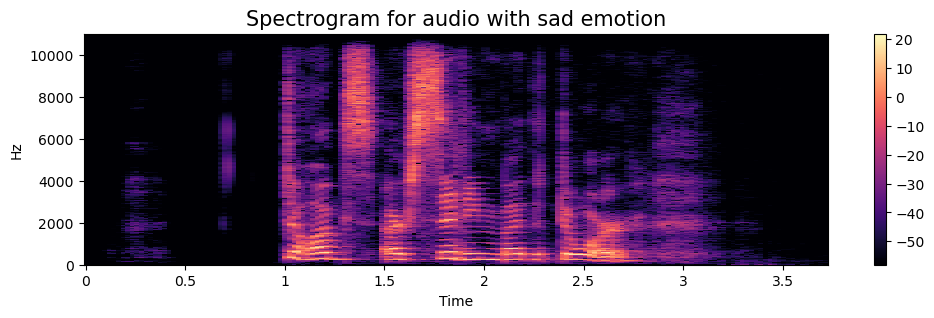

In [92]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

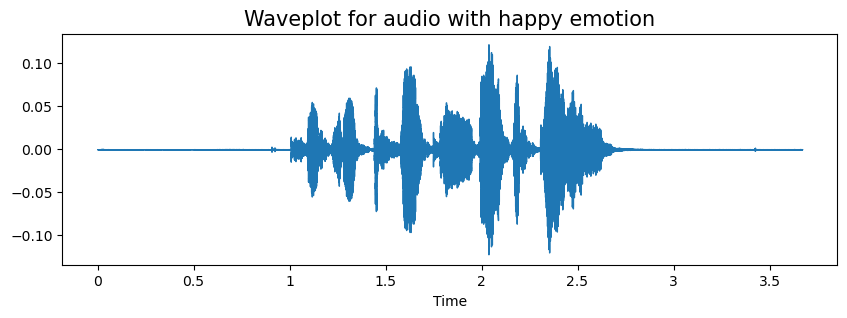

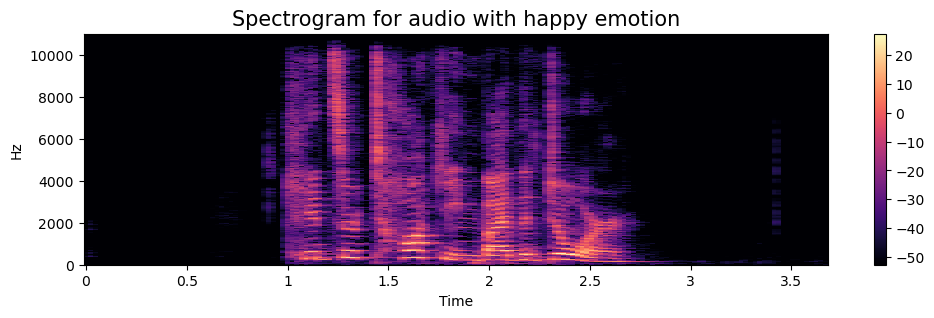

In [93]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [94]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)
print(sample_rate)

22050


#### 1. Simple Audio

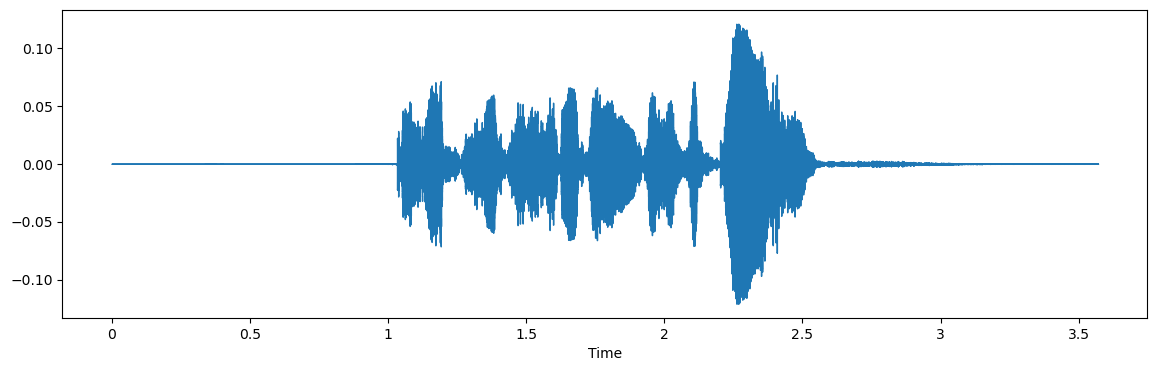

In [95]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

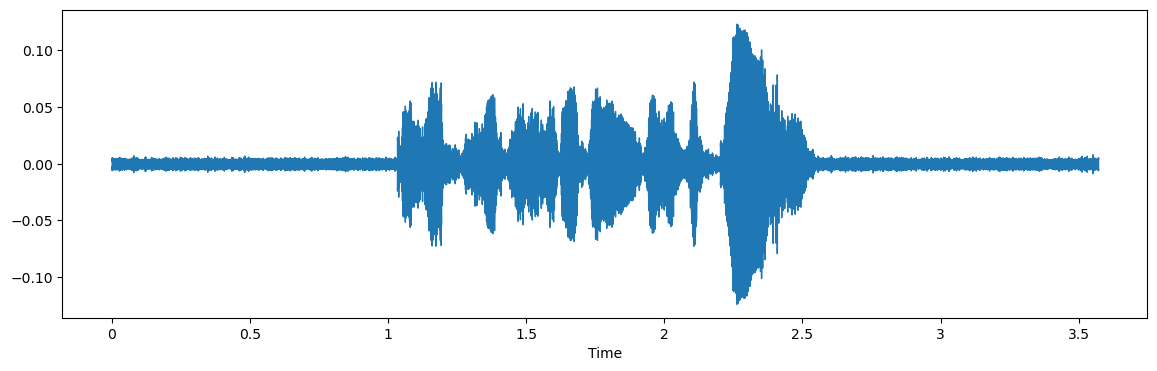

In [96]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

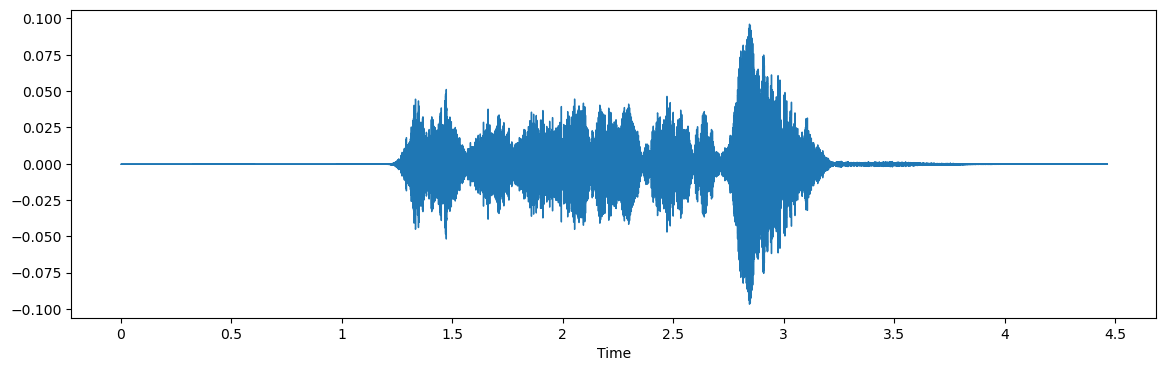

In [97]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

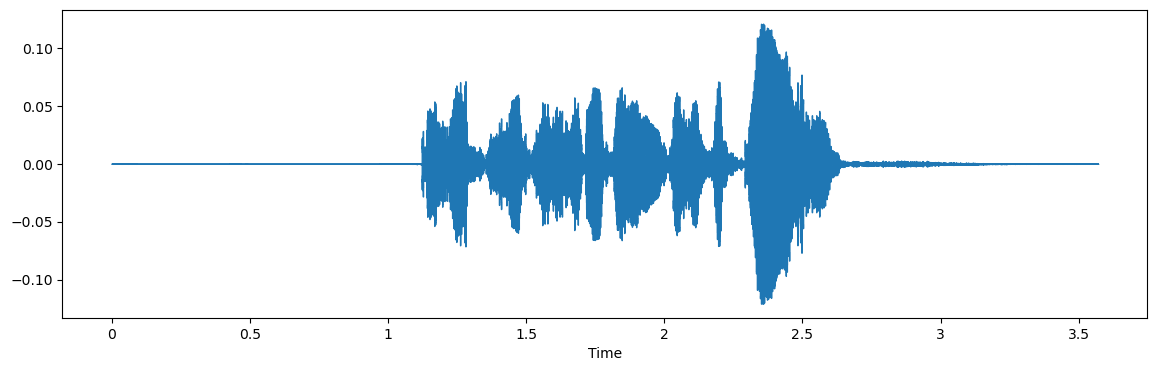

In [98]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

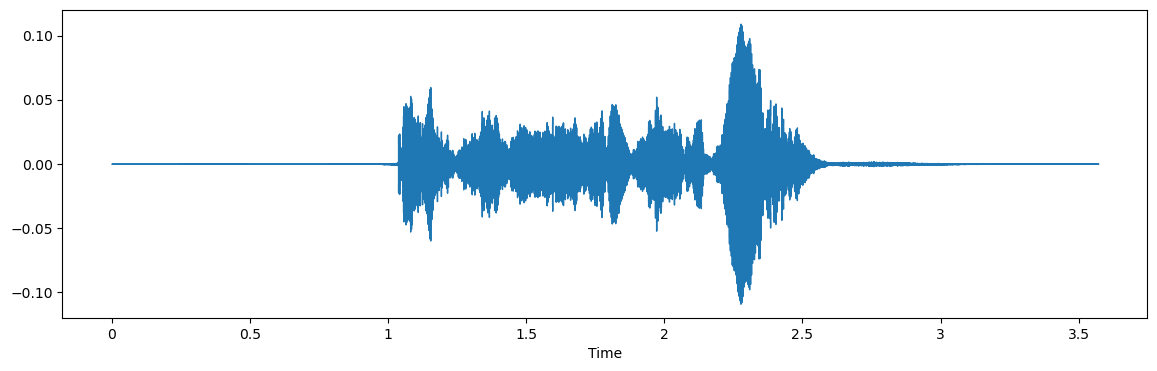

In [99]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

I am no expert on audio signals and feature extraction on audio files so i need to search and found a very good blog written by [Askash Mallik](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225) on feature extraction.

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [100]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [104]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    print(path)
    print(emotion)
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_16/03-01-06-01-02-02-16.wav
fear
input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_16/03-01-06-02-01-02-16.wav
fear
input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_16/03-01-05-02-01-01-16.wav
angry
input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_16/03-01-07-01-01-01-16.wav
disgust
input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_16/03-01-04-01-01-02-16.wav
sad
input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_16/03-01-04-02-02-02-16.wav
sad
input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_16/03-01-07-02-02-01-16.wav
disgust
input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_16/03-01-08-02-02-01-16.wav
surprise
input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_16/03-01-08-01-01-01-16.wav
surprise
input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_

In [103]:
len(X), len(Y), data_path.Path.shape

(1497, 1497, (12162,))

In [105]:
print(X)
print(Y)

[array([ 1.84814453e-01,  5.52938759e-01,  5.14264464e-01,  4.77355123e-01,
        4.08057451e-01,  3.59502226e-01,  3.94911379e-01,  4.05739456e-01,
        4.33439285e-01,  4.97810632e-01,  5.69780350e-01,  5.76485634e-01,
        5.76392889e-01, -4.85625336e+02,  5.47071724e+01, -1.08766603e+01,
        8.66698837e+00, -5.45826054e+00, -1.14757042e+01, -2.26518059e+01,
       -1.81663876e+01, -1.42780190e+01,  3.03471422e+00, -1.98873367e+01,
       -9.10740757e+00,  1.36851087e-01, -7.80562496e+00, -1.02574415e+01,
       -4.13863230e+00, -9.59003067e+00, -2.84209943e+00, -7.42683983e+00,
       -4.47845793e+00,  1.26814889e-02,  3.87100590e-05,  5.54243015e-05,
        7.50484687e-05,  9.22682739e-05,  5.57694875e-04,  6.29983144e-03,
        5.94592355e-02,  2.38523990e-01,  4.17196602e-01,  9.80802298e-01,
        7.38634527e-01,  3.37962776e-01,  2.69392341e-01,  2.53855705e-01,
        1.33446887e-01,  6.81386217e-02,  7.31905922e-02,  1.83825865e-01,
        3.69670063e-01, 

In [106]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.184814  0.552939  0.514264  0.477355  0.408057  0.359502  0.394911   
1  0.290419  0.714162  0.716269  0.705888  0.631495  0.617135  0.568811   
2  0.193493  0.616599  0.621816  0.581312  0.521695  0.420483  0.368143   
3  0.197709  0.603847  0.551309  0.521891  0.428984  0.316506  0.365429   
4  0.270300  0.616199  0.622020  0.581978  0.487521  0.485178  0.534915   

          7         8         9  ...       153       154       155       156  \
0  0.405739  0.433439  0.497811  ...  0.002602  0.002953  0.003854  0.003141   
1  0.558048  0.569999  0.615282  ...  0.002701  0.003062  0.003935  0.003220   
2  0.431577  0.455142  0.489380  ...  0.001166  0.000600  0.000603  0.000821   
3  0.482508  0.540940  0.606378  ...  0.005543  0.009786  0.009472  0.012918   
4  0.580675  0.643802  0.646199  ...  0.006816  0.011318  0.011235  0.014438   

        157       158       159       160           161  labels  
0  0.002715  0.001565  0.000508  0.000056  7.527195e-07    fear  
1  0.002783  0.001644  0.000604  0.000133  8.421940e-05    fear  
2  0.001039  0.000461  0.000102  0.000006  5.605840e-08    fear  
3  0.011940  0.005602  0.001454  0.000162  3.943526e-06    fear  
4  0.013279  0.007043  0.003107  0.001842  1.665710e-03    fear  

[5 rows x 163 columns]

* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [107]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
print(X[20:30])
print(Y[20:30])

[[2.34711372e-01 5.59938431e-01 5.50760984e-01 ... 2.43109651e-04
  1.05978115e-05 9.94322917e-08]
 [2.38588686e-01 6.68144643e-01 7.37078428e-01 ... 1.56205299e-03
  1.08593085e-04 3.00627926e-06]
 [3.28812211e-01 7.37670630e-01 8.26469234e-01 ... 5.95545085e-03
  4.28785376e-03 4.20375511e-03]
 ...
 [2.36391421e-01 6.37045681e-01 5.83427310e-01 ... 1.37379183e-03
  1.44561956e-04 1.63030279e-06]
 [2.92267976e-01 6.91840291e-01 6.66338679e-01 ... 1.62262951e-03
  4.25834459e-04 2.77747991e-04]
 [2.19462529e-01 7.16301680e-01 6.49444938e-01 ... 2.01633738e-04
  1.48025874e-05 7.86435237e-08]]
['disgust' 'surprise' 'surprise' 'surprise' 'surprise' 'surprise'
 'surprise' 'happy' 'happy' 'happy']


In [108]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
print(Y[20:30])

[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]


In [111]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1122, 162), (1122, 8), (375, 162), (375, 8))

In [112]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
scaler.fit(x_train)

print("Not Scaled ",x_train)
x_train = scaler.transform(x_train)
print("Scaled ",x_train)

import pickle
pickle.dump(scaler, open('scaler.pkl','wb'))

x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

Not Scaled  [[9.65214482e-02 5.52444875e-01 5.41297257e-01 ... 1.60042720e-04
  1.13010674e-05 1.26646583e-07]
 [1.99348958e-01 5.63382149e-01 6.40244663e-01 ... 1.77010021e-04
  8.76338618e-06 3.74332991e-08]
 [1.96126302e-01 5.08604944e-01 5.36825895e-01 ... 1.14021423e-04
  6.79428558e-06 1.15196826e-07]
 ...
 [2.05986871e-01 5.28484046e-01 5.56355932e-01 ... 1.20582000e-04
  3.66860452e-05 2.37676203e-05]
 [3.34242079e-01 6.54760162e-01 6.88004027e-01 ... 3.94440546e-02
  3.32479493e-02 3.10889041e-02]
 [1.85058594e-01 6.24828875e-01 5.43694913e-01 ... 1.19871798e-03
  1.07175394e-04 2.15298110e-06]]
Scaled  [[-1.44927377 -0.742995   -0.81534158 ... -0.17895594 -0.16709948
  -0.16497809]
 [ 0.00802195 -0.6149514   0.24129037 ... -0.17619985 -0.16753355
  -0.16499344]
 [-0.03765029 -1.25623288 -0.86309001 ... -0.18643141 -0.16787037
  -0.16498006]
 ...
 [ 0.10209601 -1.0235065  -0.65453415 ... -0.18536574 -0.16275736
  -0.16091115]
 [ 1.91975906  0.45481893  0.7512994  ...  6.202147

((1122, 162), (1122, 8), (375, 162), (375, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

## Modelling

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 81, 256)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 81, 256)           327936    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 41, 256)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 128)          

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test), callbacks=[rlrp])

Train on 27364 samples, validate on 9122 samples
Epoch 1/5
27364/27364 [==============================] - 313s 11ms/sample - loss: 1.4529 - accuracy: 0.4131 - val_loss: 1.3202 - val_accuracy: 0.4665
Epoch 2/5
27364/27364 [==============================] - 308s 11ms/sample - loss: 1.3692 - accuracy: 0.4536 - val_loss: 1.2370 - val_accuracy: 0.5092
Epoch 3/5
27364/27364 [==============================] - 459s 17ms/sample - loss: 1.3077 - accuracy: 0.4791 - val_loss: 1.2080 - val_accuracy: 0.5195
Epoch 4/5
27364/27364 [==============================] - 331s 12ms/sample - loss: 1.2696 - accuracy: 0.4947 - val_loss: 1.2074 - val_accuracy: 0.5203
Epoch 5/5
27364/27364 [==============================] - 306s 11ms/sample - loss: 1.2337 - accuracy: 0.5063 - val_loss: 1.1807 - val_accuracy: 0.5315


In [ ]:
model.save('savedmodel.h5')

from tensorflow import keras
from tensorflow.keras.models import load_model


loaded_model = load_model("savedmodel.h5")

In [ ]:
print("Accuracy of our model on test data : " , loaded_model.evaluate(x_test,y_test)[1]*100 , "%")

# epochs = [i for i in range(50)]
# fig , ax = plt.subplots(1,2)
# train_acc = history.history['accuracy']
# train_loss = history.history['loss']
# test_acc = history.history['val_accuracy']
# test_loss = history.history['val_loss']

# fig.set_size_inches(20,6)
# ax[0].plot(epochs , train_loss , label = 'Training Loss')
# ax[0].plot(epochs , test_loss , label = 'Testing Loss')
# ax[0].set_title('Training & Testing Loss')
# ax[0].legend()
# ax[0].set_xlabel("Epochs")

# ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
# ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
# ax[1].set_title('Training & Testing Accuracy')
# ax[1].legend()
# ax[1].set_xlabel("Epochs")
# plt.show()

9122/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
# predicting on test data.
pred_test = loaded_model.predict(x_test)

y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

print(y_pred)

[['angry']
 ['surprise']
 ['disgust']
 ...
 ['sad']
 ['sad']
 ['sad']]


In [ ]:
print(pred_test)

[[5.0281572e-01 3.5285007e-05 7.5466886e-02 ... 2.4093443e-03
  4.0034568e-03 3.7046110e-03]
 [7.5701936e-03 8.2799531e-08 2.1650501e-02 ... 8.5251631e-05
  5.2543283e-03 9.0482479e-01]
 [1.3613640e-01 8.3834054e-03 3.7994176e-01 ... 9.0016313e-02
  5.2886181e-02 2.4543753e-02]
 ...
 [1.2759011e-02 1.1474495e-04 2.2297065e-01 ... 1.7394368e-01
  3.1372592e-01 3.5629608e-04]
 [1.7943302e-02 1.3596677e-04 1.9589998e-01 ... 1.6696569e-01
  2.8943366e-01 9.6429023e-04]
 [3.8326427e-05 9.7415995e-09 7.8590371e-02 ... 2.7937679e-02
  8.4552681e-01 2.5641722e-05]]


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0            angry         angry
1         surprise      surprise
2          disgust       disgust
3            happy         angry
4              sad           sad
5            angry         happy
6             calm          calm
7              sad           sad
8             fear           sad
9            happy      surprise

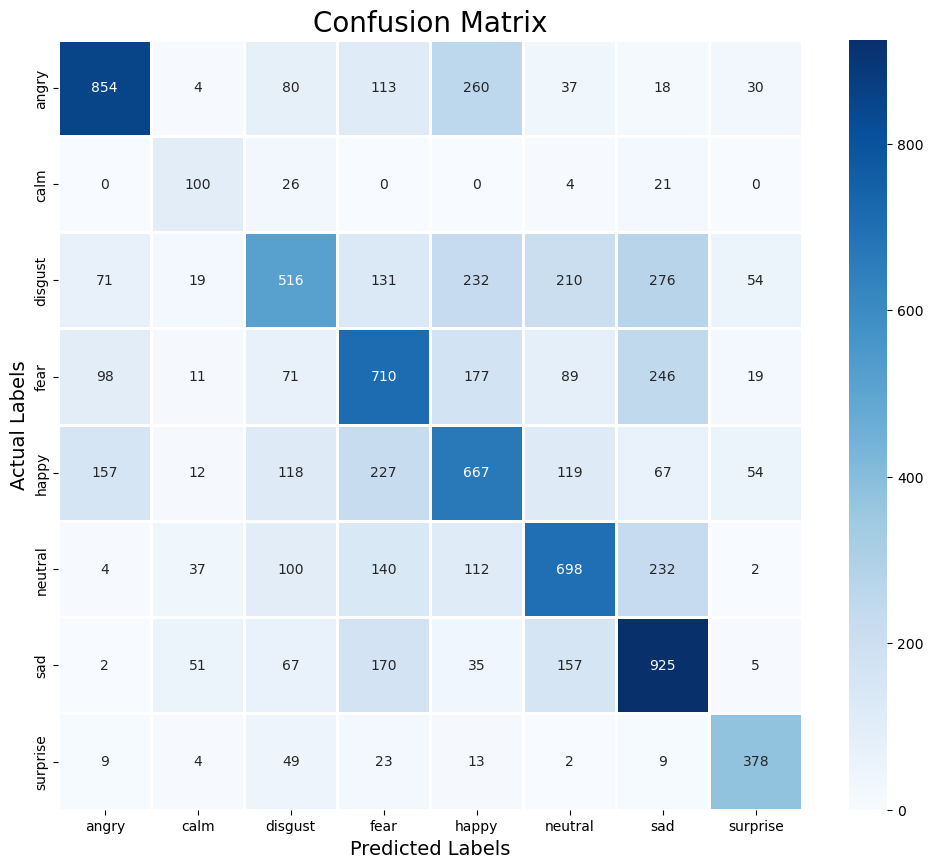

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.71      0.61      0.66      1396
        calm       0.42      0.66      0.51       151
     disgust       0.50      0.34      0.41      1509
        fear       0.47      0.50      0.48      1421
       happy       0.45      0.47      0.46      1421
     neutral       0.53      0.53      0.53      1325
         sad       0.52      0.66      0.58      1412
    surprise       0.70      0.78      0.73       487

    accuracy                           0.53      9122
   macro avg       0.54      0.57      0.55      9122
weighted avg       0.54      0.53      0.53      9122



In [ ]:
## Added by divya


src = '/Users/divya/Desktop/fear.wav'

data, sample_rate = librosa.load(src)
Feature_list = get_features(src)
